## 7.4

Return to the permeability problem outlined in Exercise 6.2. Train several nonlinear regression models and evaluate the resampling and test set performance.

**(a)** Which nonlinear regression model gives the optimal resampling and test set performance?

**(b)** Do any of the nonlinear models outperform the optimal linear model you previously developed in Exercise 6.2? If so, what might this tell you about the underlying relationship between the predictors and the response?

**(c)** Would you recommend any of the models you have developed to replace the permeability laboratory experiment?

In [ ]:
# Notes -------------------------------------

# Find out what preprocessing was used in Q6.2
# - Only PCA was used.

# What was the r2 for the linear models. (100 trials)
# - OLS               -3.6e23 
# - OLS with PCA      0.34
# - PLS               0.28
# - L1 regularisation 0.38
# - L2 regularisation 0.19

# Non-linear regression models
# Neural Networks
# o Implement a single example of nn regressor
# - Implement cross validation for nn
# - Test cross validation for baseline architecture
# - Google and implement better architectures.

# MARS
# SVM
# KNN

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from matplotlib import cm
from pyearth import Earth
import tensorflow as tf
from tensorflow import keras

In [4]:
from sklearn.model_selection import train_test_split

def split_data(df, target, val_size=0.2, test_size=0.2, drop_columns=[]):
    x={}
    y={}
    
    train_val, test = train_test_split(df, test_size=test_size)
    train, val = train_test_split(train_val, test_size=val_size/(1-test_size))
    ds = {}
    x["train"] = train.drop(columns=[target]+drop_columns)
    x["val"] = val.drop(columns=[target]+drop_columns)
    x["train_val"] = train_val.drop(columns=[target]+drop_columns)
    x["test"] = test.drop(columns=[target]+drop_columns)
    y["train"] = train[target]
    y["val"] = val[target]
    y["train_val"] = train_val[target]
    y["test"] = test[target]
    
    return x,y

In [5]:
# Loading Data ------------------------------

fingerprints = pd.read_csv("data/fingerprints.csv", index_col="ID", header=0)
permeability = pd.read_csv("data/permeability.csv", index_col="ID", header=0)

data = pd.concat([fingerprints, permeability], axis="columns")
x, y = split_data(data, "permeability")

In [30]:
# Preprocessing -----------------------------
pca95, pca99 = PCA(n_components=0.95), PCA(n_components=0.99)
pca95.fit(x["train_val"])
pca99.fit(x["train_val"])

x_pca95, x_pca99 = {}, {}
for key in x:
    x_pca95[key] = pca95.transform(x[key])
    x_pca99[key] = pca99.transform(x[key])

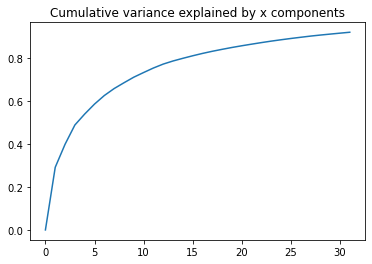

In [23]:
plt.plot([sum(pca.explained_variance_ratio_[:i]) for i in range(len(pca.explained_variance_ratio_[:i]))])
plt.title("Cumulative variance explained by x components")
plt.show()

In [39]:
# NN without PCA

x_tensor, y_tensor = {}, {}

for key in x:
    x_tensor[key] = tf.convert_to_tensor(x[key])
    y_tensor[key] = tf.convert_to_tensor(y[key])

In [40]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

loss_fn = tf.keras.losses.MeanSquaredError()

# Stop training early if no improvement in validation error
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-2,
        patience=5 #No improvement for 5 iterations
    )
]

model.compile(optimizer='adam',
              loss=loss_fn)

In [41]:
model.fit(
    x_tensor["train_val"], 
    y_tensor["train_val"], 
    validation_split=0.25, 
    callbacks=callbacks,
    epochs=500)

Epoch 1/500
4/4 [==============================] - 1s 99ms/step - loss: 234.3306 - val_loss: 669.0680
Epoch 2/500
4/4 [==============================] - 0s 49ms/step - loss: 215.3463 - val_loss: 567.9426
Epoch 3/500
4/4 [==============================] - 0s 45ms/step - loss: 195.7373 - val_loss: 494.3609
Epoch 4/500
4/4 [==============================] - 0s 54ms/step - loss: 165.4078 - val_loss: 450.6317
Epoch 5/500
4/4 [==============================] - 0s 77ms/step - loss: 169.4261 - val_loss: 427.4632
Epoch 6/500
4/4 [==============================] - 0s 77ms/step - loss: 140.5716 - val_loss: 422.4362
Epoch 7/500
4/4 [==============================] - 0s 66ms/step - loss: 151.5911 - val_loss: 411.4763
Epoch 8/500
4/4 [==============================] - 0s 63ms/step - loss: 123.4936 - val_loss: 401.2246
Epoch 9/500
4/4 [==============================] - 0s 52ms/step - loss: 126.2548 - val_loss: 382.1119
Epoch 10/500
4/4 [==============================] - 0s 69ms/step - loss: 121.1941 

In [42]:
r2_score(y_tensor["test"].numpy(), model.predict(x_tensor["test"]).reshape(-1))

0.2607339264919043

In [137]:
mean_squared_error(y_tensor["test"].numpy(), model.predict(x_tensor["test"]).reshape(-1))**0.5

11.872260667526938

In [43]:
# NN with PCA

x_tensor, y_tensor = {}, {}

for key in x:
    x_tensor[key] = tf.convert_to_tensor(x_pca99[key])
    y_tensor[key] = tf.convert_to_tensor(y[key])

In [44]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

loss_fn = tf.keras.losses.MeanSquaredError()

# Stop training early if no improvement in validation error
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-2,
        patience=5 #No improvement for 5 iterations
    )
]

model.compile(optimizer='adam',
              loss=loss_fn)

In [45]:
model.fit(
    x_tensor["train_val"], 
    y_tensor["train_val"], 
    validation_split=0.25, 
    callbacks=callbacks,
    epochs=500)

Epoch 1/500
4/4 [==============================] - 1s 132ms/step - loss: 269.9696 - val_loss: 759.1102
Epoch 2/500
4/4 [==============================] - 0s 61ms/step - loss: 266.3781 - val_loss: 748.4580
Epoch 3/500
4/4 [==============================] - 0s 46ms/step - loss: 230.7899 - val_loss: 737.1624
Epoch 4/500
4/4 [==============================] - 0s 64ms/step - loss: 259.6986 - val_loss: 725.5552
Epoch 5/500
4/4 [==============================] - 0s 70ms/step - loss: 254.3747 - val_loss: 713.1830
Epoch 6/500
4/4 [==============================] - 0s 73ms/step - loss: 198.0151 - val_loss: 699.4839
Epoch 7/500
4/4 [==============================] - 0s 64ms/step - loss: 240.8214 - val_loss: 684.6788
Epoch 8/500
4/4 [==============================] - 0s 75ms/step - loss: 187.5634 - val_loss: 668.2751
Epoch 9/500
4/4 [==============================] - 0s 70ms/step - loss: 192.6757 - val_loss: 649.6447
Epoch 10/500
4/4 [==============================] - 0s 42ms/step - loss: 175.3550

In [46]:
r2_score(y_tensor["test"].numpy(), model.predict(x_tensor["test"]).reshape(-1))

0.23575353846105263